In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the paths to the dataset
train_dir = r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped2\train\train001'
test_dir = r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped2\test\test001'

# Function to load images from a directory
def load_images_from_directory(directory, size=(416, 416)):
    images = []
    filenames = []
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)  # Resize to the input size of YOLOv3
            images.append(img)
            filenames.append(filename)
    images = np.array(images)
    return images, filenames

# Load train and test images
train_images, _ = load_images_from_directory(train_dir)
test_images, test_filenames = load_images_from_directory(test_dir)

print(f"Training images shape: {train_images.shape}")
print(f"Testing images shape: {test_images.shape}")


Training images shape: (120, 416, 416, 3)
Testing images shape: (180, 416, 416, 3)


In [2]:
# Load YOLO model and configuration files
yolo_weights = 'yolov3.weights'  # Path to YOLO weights file
yolo_config = 'yolov3.cfg'       # Path to YOLO config file
yolo_classes = 'coco.names'      # Path to file containing class names

# Load YOLO network
net = cv2.dnn.readNet(yolo_weights, yolo_config)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load class names
with open(yolo_classes, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print(f"Loaded {len(classes)} classes.")


Loaded 80 classes.


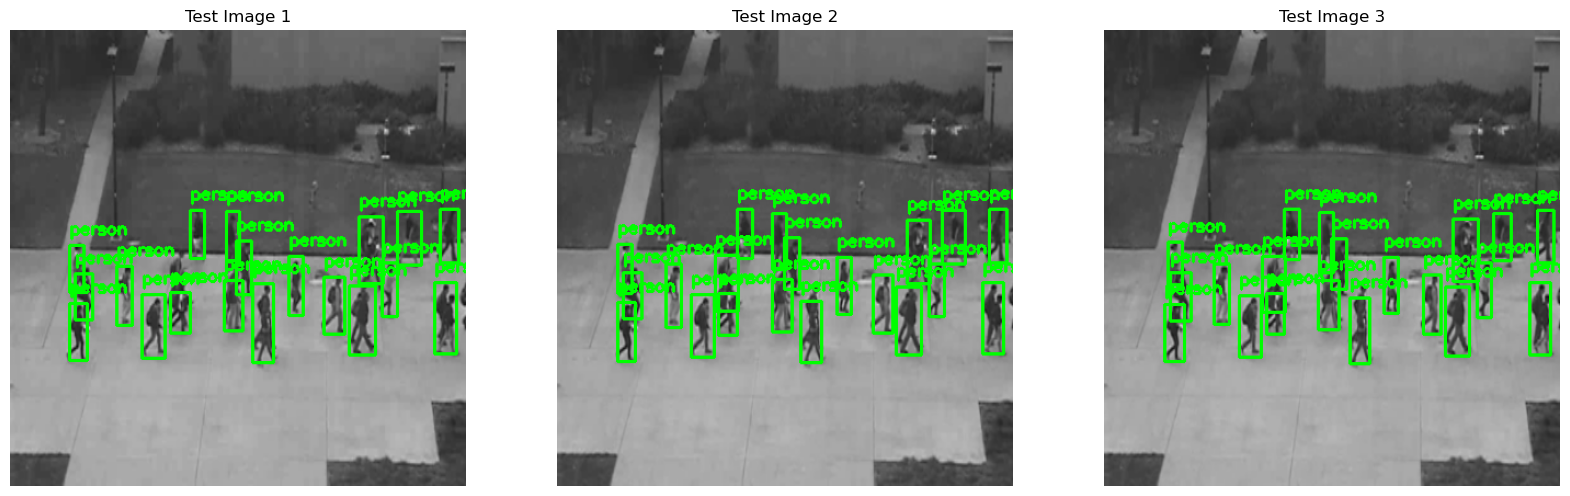

In [5]:
# Function to perform object detection
def detect_objects(img, net, output_layers):
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)
    return detections

# Function to draw bounding boxes
def draw_bounding_boxes(img, detections, classes, confidence_threshold=0.5):
    height, width = img.shape[:2]
    boxes = []
    confidences = []
    class_ids = []

    for detection in detections:
        for object_detection in detection:
            scores = object_detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                center_x = int(object_detection[0] * width)
                center_y = int(object_detection[1] * height)
                w = int(object_detection[2] * width)
                h = int(object_detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, 0.4)
    result = img.copy()
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)
            cv2.rectangle(result, (x, y), (x + w, y + h), color, 2)
            cv2.putText(result, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return result, boxes, confidences, class_ids

# Perform object detection on test images
test_detections = [detect_objects(img, net, output_layers) for img in test_images]

# Draw bounding boxes on the test images
test_images_with_boxes = [draw_bounding_boxes(test_images[i], test_detections[i], classes)[0] for i in range(len(test_images))]

# Display some test images with bounding boxes
n = 3
plt.figure(figsize=(20, 10))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(cv2.cvtColor(test_images_with_boxes[i], cv2.COLOR_BGR2RGB))
    plt.title(f"Test Image {i + 1}")
    plt.axis("off")
plt.show()


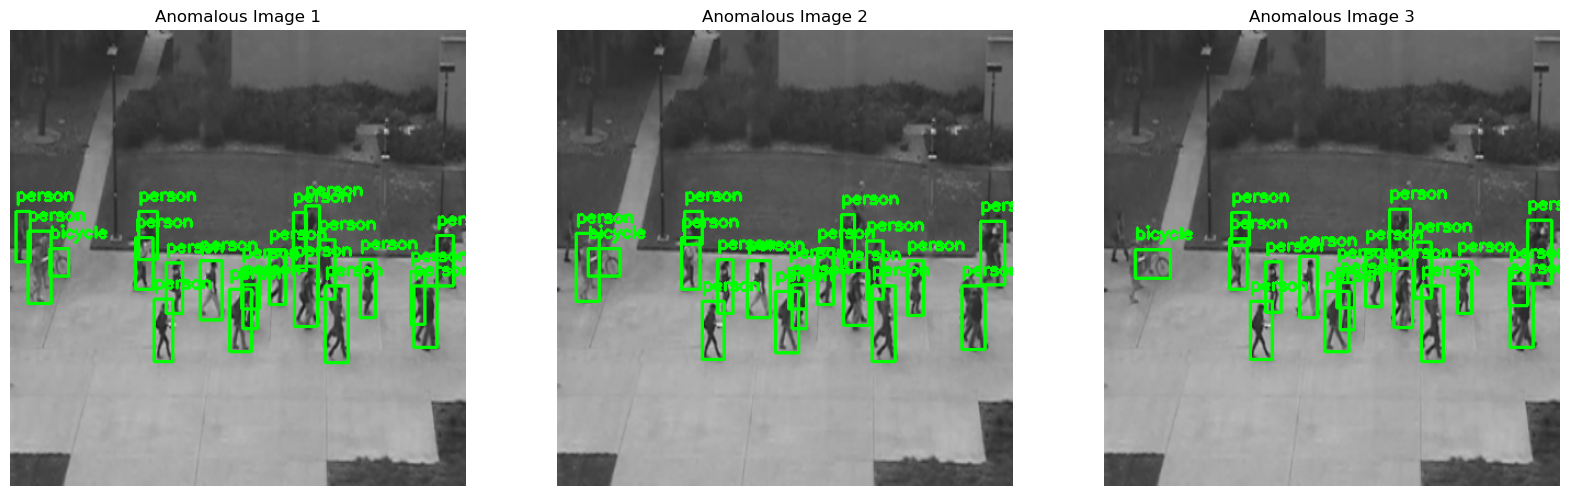

Number of anomalies detected: 89


In [6]:
# Define a set of unusual classes (anomalies)
unusual_classes = {'car', 'bicycle', 'truck'}

# Identify anomalies
anomalies = []
for i in range(len(test_images)):
    _, _, _, class_ids = draw_bounding_boxes(test_images[i], test_detections[i], classes)
    detected_classes = {classes[class_id] for class_id in class_ids}
    if detected_classes & unusual_classes:
        anomalies.append(i)

# Display anomalous images
plt.figure(figsize=(20, 10))
for i, idx in enumerate(anomalies[:n]):
    plt.subplot(1, n, i + 1)
    plt.imshow(cv2.cvtColor(test_images_with_boxes[idx], cv2.COLOR_BGR2RGB))
    plt.title(f"Anomalous Image {i + 1}")
    plt.axis("off")
plt.show()

print(f"Number of anomalies detected: {len(anomalies)}")


In [9]:
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the paths to the dataset and ground truth array
test_dir = r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped2\test\test001'
ground_truth_anomalies = np.array([[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]], dtype=np.uint8)

# Function to load images from a directory
def load_images_from_directory(directory, size=(416, 416)):
    images = []
    filenames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, size)  # Resize to the input size of YOLOv3
                images.append(img)
                filenames.append(filename)
    images = np.array(images)
    return images, filenames

# Load test images
test_images, test_filenames = load_images_from_directory(test_dir)

print(f"Testing images shape: {test_images.shape}")

# Load YOLO model and configuration files
yolo_weights = 'yolov3.weights'  # Path to YOLO weights file
yolo_config = 'yolov3.cfg'       # Path to YOLO config file
yolo_classes = 'coco.names'      # Path to file containing class names

# Load YOLO network
net = cv2.dnn.readNet(yolo_weights, yolo_config)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load class names
with open(yolo_classes, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print(f"Loaded {len(classes)} classes.")

# Function to perform object detection
def detect_objects(img, net, output_layers, confidence_threshold=0.5):
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)
    detected_classes = set()
    for detection in detections:
        for object_detection in detection:
            scores = object_detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                detected_classes.add(classes[class_id])
    return detected_classes

# Evaluate the model
y_true = []
y_pred = []

# Get the frame numbers of the images
frame_numbers = [int(os.path.splitext(filename)[0]) for filename in test_filenames]

for i, frame_number in enumerate(frame_numbers):
    # Get ground truth label for the image
    true_label = 1 if frame_number in ground_truth_anomalies else 0
    
    # Get detected classes for the image
    detections = detect_objects(test_images[i], net, output_layers)
    pred_label = 1 if 'person' in detections else 0  # Assuming 'person' detection is considered normal
    
    y_true.append(true_label)
    y_pred.append(pred_label)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Testing images shape: (180, 416, 416, 3)
Loaded 80 classes.
Precision: 0.52
Recall: 1.00
F1-score: 0.68


In [11]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

NameError: name 'accuracy_score' is not defined

In [13]:
import os
import cv2
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Define the paths to the dataset and ground truth array
test_dir = r'C:\Users\vashi\OneDrive\Desktop\video_dat\archive (2)\UCSD_Anomaly_Dataset.v1p2\UCSDped2\test\test001'
ground_truth_anomalies = np.array([[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152]], dtype=np.uint8)

# Function to load images from a directory
def load_images_from_directory(directory, size=(416, 416)):
    images = []
    filenames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.tif'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, size)  # Resize to the input size of YOLOv3
                images.append(img)
                filenames.append(filename)
    images = np.array(images)
    return images, filenames

# Load test images
test_images, test_filenames = load_images_from_directory(test_dir)

print(f"Testing images shape: {test_images.shape}")

# Load YOLO model and configuration files
yolo_weights = 'yolov3.weights'  # Path to YOLO weights file
yolo_config = 'yolov3.cfg'       # Path to YOLO config file
yolo_classes = 'coco.names'      # Path to file containing class names

# Load YOLO network
net = cv2.dnn.readNet(yolo_weights, yolo_config)
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Load class names
with open(yolo_classes, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print(f"Loaded {len(classes)} classes.")

# Function to perform object detection
def detect_objects(img, net, output_layers, confidence_threshold=0.5):
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    detections = net.forward(output_layers)
    detected_classes = set()
    for detection in detections:
        for object_detection in detection:
            scores = object_detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > confidence_threshold:
                detected_classes.add(classes[class_id])
    return detected_classes

# Evaluate the model
y_true = []
y_pred = []

# Get the frame numbers of the images
frame_numbers = [int(os.path.splitext(filename)[0]) for filename in test_filenames]

for i, frame_number in enumerate(frame_numbers):
    # Get ground truth label for the image
    true_label = 1 if frame_number in ground_truth_anomalies else 0
    
    # Get detected classes for the image
    detections = detect_objects(test_images[i], net, output_layers)
    pred_label = 1 if 'person' in detections else 0  # Assuming 'person' detection is considered normal
    
    y_true.append(true_label)
    y_pred.append(pred_label)

# Calculate precision, recall, F1-score, and accuracy
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")


Testing images shape: (180, 416, 416, 3)
Loaded 80 classes.
Precision: 0.52
Recall: 1.00
F1-score: 0.68
Accuracy: 0.52
